In [ ]:
import sys
sys.path.append("../../../")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from LRM.plotting import set_plot_style
from LRM.CMP import CMP, SmoothedEmpiricalDensity
from LRM.minimax_tilting_sampler import TruncatedMVN


set_plot_style()

RUN_COMPUTATION = False #whether to run the computation time snippets
RUN_PREDICTIVE = False #if predictive samples haven't been stored in ./results yet, set to True
SAVE=False

predictives_cmp = np.load("../../../DiscreteFisherBayes/Graphical/Res/CMPGM_FDBayes_numdim=10_numchains=4_numsample=10000_numboot=100_numpred=100_numpredsample=500000_predictives.npy")

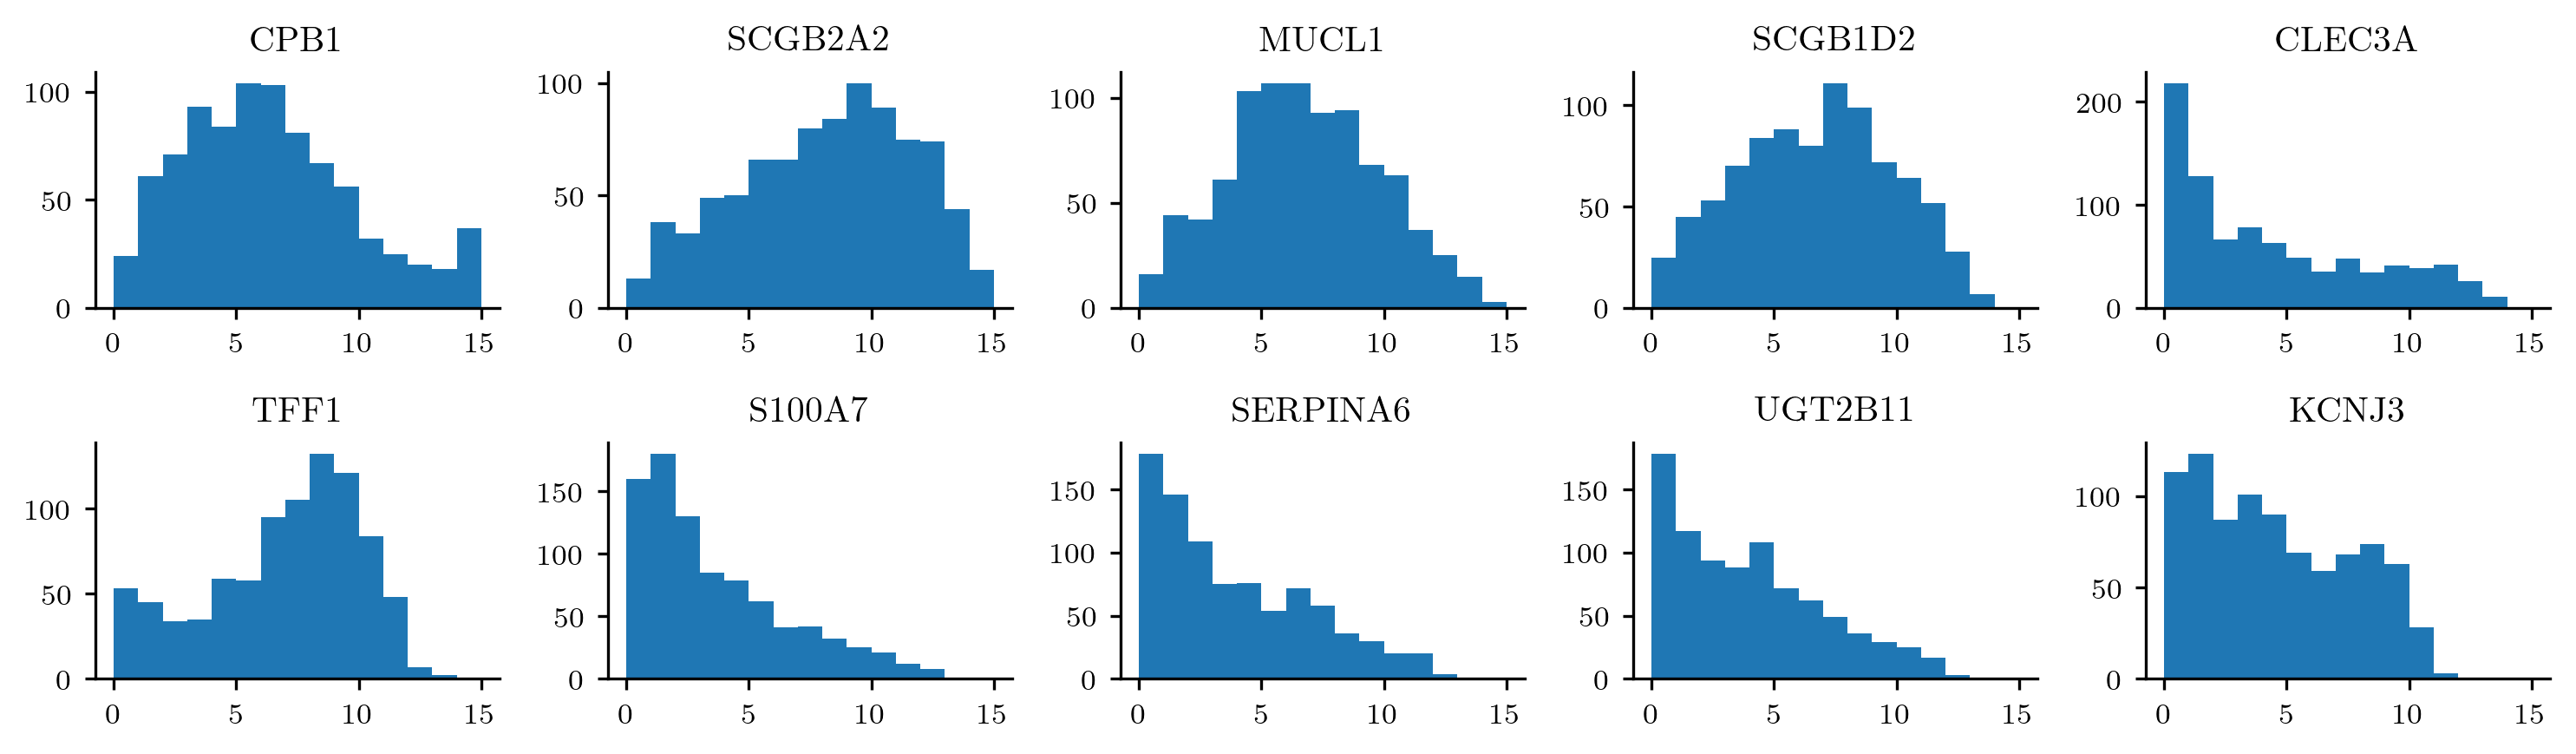

In [5]:
labels = [["CPB1", "SCGB2A2", "MUCL1", "SCGB1D2", "CLEC3A"],["TFF1", "S100A7", "SERPINA6", "UGT2B11", "KCNJ3"]]

def plot_data(samples):
    assert len(samples.shape) == 2 and samples.shape[1] == 10
    fig, axs = plt.subplots(2, 5, figsize=(10,3))

    count = 0
    for i in range(2):
        for j in range(5):
            axs[i, j].hist(samples[:, count], bins=np.arange(16))
            axs[i, j].set_title(labels[i][j])
            count+=1
    
    fig.tight_layout()

raw_data = np.load("../../../data/brca_10.npy").astype(np.int64)
plot_data(raw_data)

## Fitting $\beta$

In [6]:
#Fitting the empirical (and alpha)
empirical = SmoothedEmpiricalDensity(alpha=0.1)
empirical.fit(raw_data)

#Setup for M(x)
d = raw_data.shape[1]
j_bound = 2
model = CMP(d=d, empirical=empirical, j_vals=list(range(-j_bound, j_bound + 1)), circular=True)

#Fitting beta (coverage)
mu_prior = np.zeros((model.param_size, 1))
Sigma_prior = np.eye(model.param_size)

beta_star, cov, _ = model.fit_coverage(data=raw_data, prior_mean=mu_prior, prior_cov=Sigma_prior, B=50, beta_low=0.5, beta_high=1.5, verbose=True)

[scipy] beta*: 1.16212, coverage: 0.9600 (target 0.9500); fun=0.0001, success=True


In [7]:
if RUN_COMPUTATION:   
    times = []
    for i in range(10):
        t1 = time.time()
        #Fitting the empirical (and alpha)
        empirical = SmoothedEmpiricalDensity(alpha=0.1)
        empirical.fit(raw_data)

        #Setup for M(x)
        d = raw_data.shape[1]
        j_bound = 2
        model = CMP(d=d, empirical=empirical, j_vals=list(range(-j_bound, j_bound + 1)), circular=True)
        beta_star, cov, _ = model.fit_coverage(data=raw_data, prior_mean=mu_prior, prior_cov=Sigma_prior, B=50, beta_low=0.5, beta_high=1.5, verbose=False)
        t2 = time.time()
        times.append(t2 - t1)
    np.save("./outputs/coverage_computation_times.npy", times)

else:
    times = np.load("./outputs/coverage_computation_times.npy", allow_pickle=True)
    
print(np.mean(times)) 
print(np.std(times))

48.32129609584808
1.8725561938571036


## Posterior

In [ ]:
#Getting posterior (MVN)
beta = beta_star
posterior = model.posterior(data=raw_data, beta=beta, mu_prior=mu_prior, Sigma_prior=Sigma_prior)

# constraints
lb = np.ones_like(posterior.mean) * - np.inf
ub = np.ones_like(posterior.mean) * np.inf

lb[:] = 0.0 #ensure positivity

# create truncated normal object
tmvn = TruncatedMVN(posterior.mean, posterior.cov, lb, ub)

In [9]:
if RUN_COMPUTATION:   
    times = []
    beta=beta_star
    for i in range(10):
        t1 = time.time()
        posterior = model.posterior(data=raw_data, beta=beta, mu_prior=mu_prior, Sigma_prior=Sigma_prior)
        t2 = time.time()
        times.append(t2 - t1)

    np.save("./outputs/posterior_computation_times.npy", times)

else:
    times = np.load("./outputs/posterior_computation_times.npy", allow_pickle=True)

print(np.mean(times))
print(np.std(times))

2.152137565612793
0.11311973603382157


## Posterior Predictive

In [10]:
def metropolis_hastings(log_prob, x0, n_samples, proposal_width=1, burn_in=1000, N_MAX=30):
    d = len(x0)
    samples = []
    x = x0.copy()
    log_p_x = log_prob(x)

    for step in tqdm(range(n_samples + burn_in)):
        # Propose a new sample by modifying one random coordinate
        proposal = x.copy()
        idx = np.random.randint(d)
        move = np.random.choice([-proposal_width, proposal_width])
        proposal[idx] = np.clip(proposal[idx] + move, 0, N_MAX)

        log_p_prop = log_prob(proposal)
        accept_ratio = np.exp(log_p_prop - log_p_x)

        if np.random.rand() < accept_ratio:
            x = proposal
            log_p_x = log_p_prop

        if step >= burn_in:
            samples.append(x.copy())

    return np.array(samples)

def thin_chain(samples, thinning_interval):
    return samples[::thinning_interval]

In [11]:
def get_posterior_predictive_LRM(tmvn, model, num_theta_samples=10, N_MAX=25):
    
    predictive_data = []
    for i in tqdm(range(raw_data.shape[0])):
        params = tmvn.sample(num_theta_samples)[:, np.random.choice(num_theta_samples)]

        all_model_data = metropolis_hastings(lambda x : model.log_prob(x, params=params), x0=raw_data[0], n_samples=10_000, burn_in=5_000, N_MAX=N_MAX)
        model_data = thin_chain(all_model_data, thinning_interval=10)

        indices = np.random.choice(model_data.shape[0], size=raw_data.shape[0], replace=False)
        model_data = model_data[indices]
        predictive_data.append(model_data[np.random.choice(model_data.shape[0])])
        
    return predictive_data


In [ ]:
if RUN_PREDICTIVE:
    LRM_predictive_data = get_posterior_predictive_LRM(tmvn, model)
    np.savez("outputs/posterior_pred_samples_LRM_calibrated.npz", model_data=np.stack(LRM_predictive_data))

## Plotting

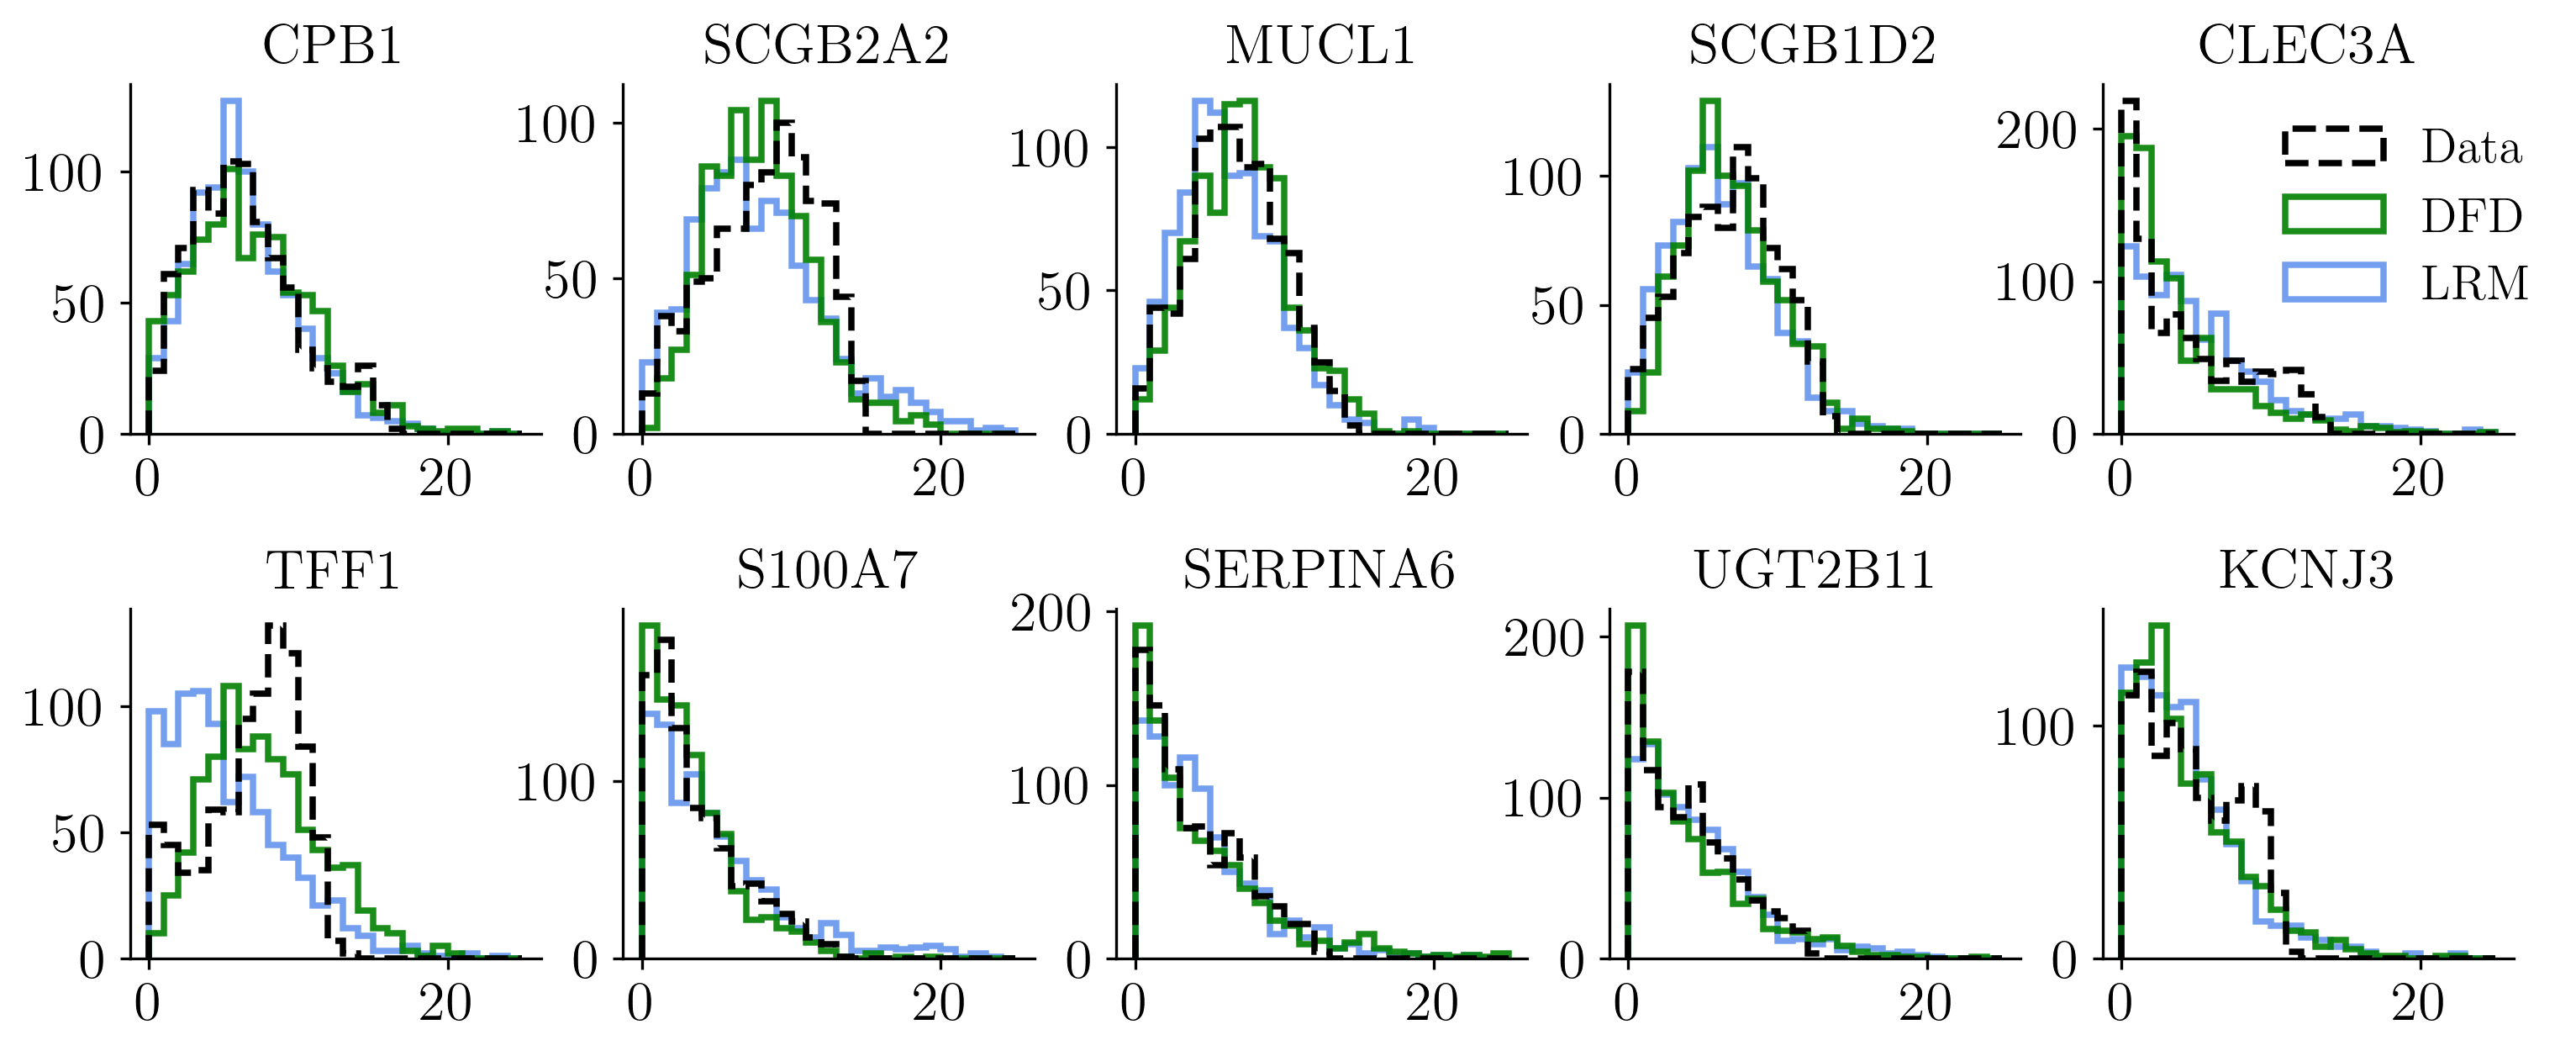

In [16]:
fig, axs = plt.subplots(2, 5, figsize=(12.2,4.5))
labels = [["CPB1", "SCGB2A2", "MUCL1", "SCGB1D2", "CLEC3A"],["TFF1", "S100A7", "SERPINA6", "UGT2B11", "KCNJ3"]]
N_MAX=25
model_data = np.load("outputs/posterior_pred_samples_LRM_calibrated.npz")["model_data"]
count = 0
lw = 1.8
for i in range(2):
    for j in range(5):
        axs[i, j].hist(raw_data[:, count], histtype='step', bins=np.arange(N_MAX+1), label="Data",color='black', linestyle='--', linewidth=lw, zorder=3)
        axs[i, j].hist(predictives_cmp[0, :, count], histtype='step', bins=np.arange(N_MAX+1), label="DFD", color='green', linestyle='-', linewidth=lw, alpha=0.9, zorder=2)
        axs[i, j].hist(model_data[:, count], histtype='step', bins=np.arange(N_MAX+1), label="LRM", color='cornflowerblue', linestyle='-', linewidth=lw, alpha=0.9, zorder=1)
        axs[i, j].set_title(labels[i][j], fontsize=16)
        count+=1

axs[0,-1].legend(frameon=False, fontsize=14, bbox_to_anchor=(1.15, 1))

for ax in axs.flat:
    ax.tick_params(axis='both', labelsize=16)

fig.subplots_adjust(hspace=0.5)

if SAVE:
    plt.savefig("./results/BRCA-fit.pdf", format='pdf', bbox_inches='tight')